In [1]:
import porespy as ps
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import radon, iradon
from scipy import ndimage

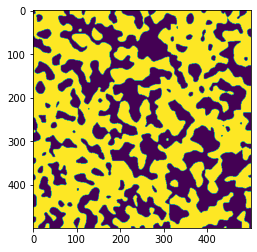

In [2]:
img = ps.generators.blobs(shape=[500, 500], porosity=0.6, blobiness=2)
plt.imshow(img)

In [13]:
def crop(img, shape, center=None):
    def left_edge(index):
        return np.ceil(center[index] - halves[index]).astype(int)

    def right_edge(index):
        return np.ceil(center[index] + halves[index] + odds[index]).astype(int)

    if center is None:
        center = [x // 2 for x in img.shape]

    halves = [x // 2 for x in shape]
    odds = [x % 2 for x in shape]

    ranges = (
        slice(
            left_edge(i),
            right_edge(i)
        )
        for i in range(img.ndim)
    )

    return img[tuple(ranges)]


def process_image(image,
                  angles_number,
                  noise_parameter,
                  noise_method,
                  pixel_size=0.01,
                  frame_count=1,
                  gauss_sigma=0.56):
    """
    :param image:
    :param angles_number:
    :param noise_parameter:
    :param noise_method: should be 'poisson' or None:
    :pixel_size:
    :frame_count:
    :gauss_sigma:
    :return:
    """
    sim = create_sinogram(angles_number, image)
    print("sinogram shape: ", sim.shape)
    if noise_method == 'poisson':
        sim, _ = add_poisson_noise_physical(sim,
                                            noise_parameter,
                                            pixel_size,
                                            frame_count,
                                            gauss_sigma)
    elif noise_method is None:
        pass
    else:
        raise ValueError("noise_method should be 'poisson' or None. Given {}".format(noise_method))
    rec = reconstruct(sim)
    print("reconstruction shape: ", rec.shape)
    return crop(rec, image.shape), crop(image, image.shape)


def create_sinogram(num_of_angles, img):
    set_of_angles = np.linspace(0, 180, num_of_angles, endpoint=False)
    if len(img.shape) == 3:
        sim = np.asarray([radon(img_slice, theta=set_of_angles, circle=False) for img_slice in img])
    else:
        sim = radon(img, theta=set_of_angles, circle=False)

    return sim


def reconstruct(sinogram):
    if len(sinogram.shape) == 3:
        set_of_angles = np.linspace(0, 180, sinogram[0].shape[1], endpoint=False)
        image = [iradon(s, set_of_angles) for s in sinogram]
    else:
        set_of_angles = np.linspace(0, 180, sinogram.shape[1], endpoint=False)
        image = iradon(sinogram, set_of_angles)

    image = np.asarray(image)

    return image


def add_poisson_noise(sinogram, intensity):
    sinogram = sinogram / 100.0  # TODO: add comment why it is so?
    I_0 = np.random.poisson(lam=intensity,
                            size=sinogram.shape
                            ).astype('float32')
    sinogram = np.exp(-sinogram) * I_0

    exposition = 10.0  # TODO: fix magic parameter

    I_0_arr = np.random.poisson(lam=intensity * exposition,
                                size=sinogram.shape).astype('float32') / exposition

    sinogram = np.log(I_0_arr / sinogram)
    sinogram *= 100.0
    sinogram = np.ceil(sinogram)

    return sinogram


def add_poisson_noise_physical(sinogram,
                               nominal_intensity,
                               pixel_size=0.02,
                               frame_count=1,
                               gauss_sigma=0.56):

    I0_empty = np.zeros(sinogram.shape)
    for i in range(frame_count):
        I0_empty += np.round(np.random.poisson(
                                      lam=nominal_intensity,
                                      size=sinogram.shape
                                     ))
    I0_empty /= frame_count 

    I0 = np.random.poisson(lam=nominal_intensity,
                           size=sinogram.shape
                          ).astype('float32')

    experimental_sinogram = I0*np.exp(- sinogram * pixel_size)
    experimental_sinogram = sinogram_detector_blurring(experimental_sinogram, gauss_sigma).astype(int)

    #TODO: here we get rid of zero values. Make it more flexible
    experimental_sinogram[experimental_sinogram < 1] = 1

    noised_radon_sinogram = np.log(I0_empty/experimental_sinogram) / pixel_size
    
    return noised_radon_sinogram, experimental_sinogram


def sinogram_detector_blurring(sinograms, gauss_sigma):
    if not gauss_sigma:
        return sinograms

    _sinograms = np.copy(sinograms).astype(float)
    dim = len(_sinograms.shape)
    num_of_angles = _sinograms.shape[2] if dim == 3 else _sinograms.shape[1]
    result = np.empty_like(_sinograms)
    for angle in np.arange(num_of_angles):
        projection = _sinograms[:, :, angle] if dim == 3 else _sinograms[:, angle]
        projection_dim = len(projection.shape)
        for axis in np.arange(projection_dim):
            output = ndimage.gaussian_filter1d(projection, gauss_sigma, axis)
            projection = output
        result[:, angle] = projection
    return result

In [16]:
rec, img = process_image(img,
                         90,
                         1000,
                         'poisson',
                         pixel_size=0.01,
                         frame_count=1,
                         gauss_sigma=0.56)

sinogram shape:  (708, 90)
reconstruction shape:  (708, 708)


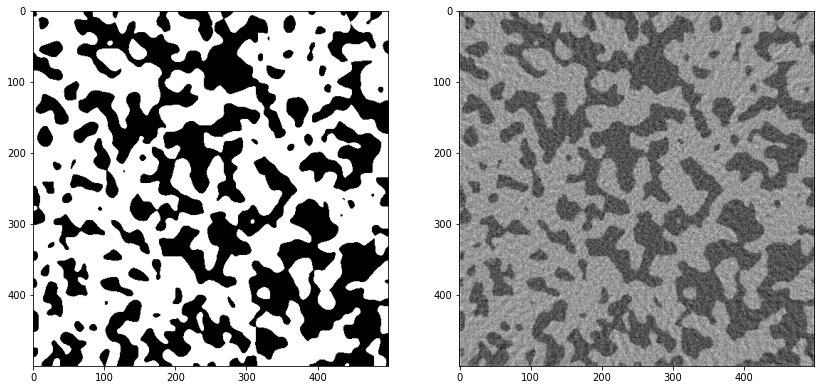

In [17]:
fig, axes = plt.subplots(ncols=2, figsize = (14, 7))
axes[0].imshow(img, cmap="gray")
axes[1].imshow(rec, cmap="gray")